In [1]:
import os
import numpy as np
from glob import glob
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
os.path.join("a", "b", "c")

'a\\b\\c'

In [3]:
class PASTISSegmentation:
    """
    Here we use a subset of the PASTIS dataset: https://github.com/VSainteuf/pastis-benchmark
    """
    def __init__(
        self,
        image_dir: str,
        annotation_dir: str,
        split:str = "train",
        median_of_days: bool = False,
        binary_labels: bool = False
    ) -> None:
        
        images = glob(os.path.join(image_dir, split, 'S2_*.npy'))
        annotations = []
        for im in images:
            name = os.path.splitext(os.path.basename(im))[0].replace("S2_", "")
            annotations.append(os.path.join(annotation_dir, split, f"TARGET_{name}.npy"))

        # Store in the class for future reference
        self.median_of_days = median_of_days
        self.binary_labels = binary_labels
        
        # Load data
        self.X = self.read_data(images)
        if median_of_days:
            self.X = np.median(self.X, axis=1) #Take median value across 43 days

        self.y = self.read_data(annotations)
        self.y = self.y[:,0] # We are only interested in the 20 classes for now
        if binary_labels:
            self.y[self.y>0] = 1 # Convert to binary labels
        
    def __len__(self):
        return self.X.shape[0]
    
    def read_data(self, files):
        """
        Reads and stacks our data
        """
        t = []
        for im in files:
            t.append(np.load(im))
        return np.stack(t, axis=0)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def pixelwise(self):
        """
        This method flattens our images to individual pixels, so we can treat
        each pixel as a sample and train our favirote classifier on it. 
        """
        if self.median_of_days:
            return  np.transpose(self.X, (0, 2, 3, 1)).reshape(-1, 10), self.y.reshape(-1)
        else:
            return  np.transpose(self.X, (0, 3, 4, 1, 2)).reshape(-1, 430), self.y.reshape(-1)
    
    def pixelwise_test(self):
        """
        Short test for the above method.
        """
        N = self.__len__()
        
        pX, py = self.pixelwise()
        if self.median_of_days:
            tX = np.transpose(pX.reshape(N, 128, 128, 10), (0, 3, 1, 2))    
        else:
            tX = np.transpose(pX.reshape(N, 128, 128, 43, 10), (0, 3, 4, 1, 2))
        tY = py.reshape(N, 128, 128)
        assert np.all(tX == self.X) and np.all(tY == self.y)
        print("All test passed!")

In [4]:
base_path = "C:/Users/birgi/Desktop/Geoinformatics M.Sc/Big DAta/data_week2" # Define it
p_train = PASTISSegmentation(os.path.join(base_path, "data", "images"),
                             os.path.join(base_path, "data", "annotations"),
                             split="train",
                             median_of_days=True,
                             binary_labels=False)

p_test = PASTISSegmentation(os.path.join(base_path, "data", "images"),
                             os.path.join(base_path, "data", "annotations"),
                            split="test",
                            median_of_days=True,
                            binary_labels=False)
p_train.pixelwise_test()
p_test.pixelwise_test()

X_train, y_train = p_train.pixelwise()
X_test, y_test = p_test.pixelwise()

All test passed!
All test passed!


In [5]:
# Instead of images, we focus on the individual pixels. For each pixel, we have 10 features and a class (in y).
X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((245760, 10), (245760,), (81920, 10), (81920,))

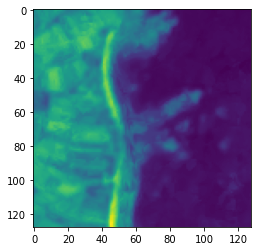

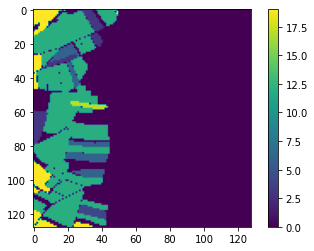

In [6]:
imd = 5
# Show the 3rd band of the third image
plt.imshow(p_train.X[imd, 3])
plt.show()

# Show the labels for third image
plt.imshow(p_train.y[imd])
plt.colorbar()
plt.show()

# Logistic Regression

In [7]:
# TODO: Define the logistic classifier and fit it on the training set (X_train, y_train)
# Hint: If using sklearn set n_jobs=-1 for parallezing the model fit
logistic_regressor = LogisticRegression(random_state=0, solver="saga", n_jobs=-1, max_iter = 100).fit(X_train, y_train)
y_pred_prob = logistic_regressor.predict(X_test)

C:\Users\birgi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [8]:
# TODO: Validate on the validation data (X_test, y_test: accuracy, recall, and precision).
print(sklearn.metrics.classification_report(y_test, y_pred_prob))

              precision    recall  f1-score   support

           0       0.36      0.66      0.46     24249
           1       0.49      0.45      0.47     21849
           2       0.28      0.32      0.30      3891
           3       0.51      0.12      0.20      8033
           4       0.07      0.01      0.01      1345
           5       0.08      0.20      0.12       310
           6       0.20      0.00      0.00      3295
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00       216
          12       0.38      0.24      0.30      7582
          13       0.35      0.40      0.37       970
          14       0.00      0.00      0.00      3421
          16       0.00      0.00      0.00       101
          17       0.00      0.00      0.00       412
          19       0.26      0.09      0.13      6246

    accuracy                           0.38     81920
   macro avg       0.20      0.17      0.16     81920
weighted avg       0.37   

C:\Users\birgi\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\birgi\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\birgi\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\

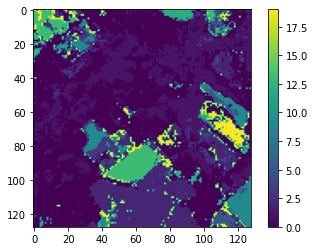

In [11]:
# TODO: Display the results in an image for one of the images in the test set

tpb = y_pred_prob.copy().reshape(-1, 128, 128)
plt.imshow(tpb[3])
plt.colorbar()
plt.show()


# Random Forest

In [9]:
# TODO: Define the  Random Forest classifier and fit it on the training set (X_train, y_train)
# Hint: If using sklearn set n_jobs=-1 for parallezing the model fit

from sklearn.ensemble import RandomForestClassifier

random_forest =  RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0, n_jobs=-1).fit(X_train, y_train)
rf_pred = random_forest.predict(X_test)

In [10]:
# TODO: Validate on the validation data (X_test, y_test: accuracy, recall, and precision). 
print(sklearn.metrics.classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.44      0.83      0.58     24249
           1       0.63      0.42      0.51     21849
           2       0.28      0.38      0.32      3891
           3       0.36      0.13      0.19      8033
           4       0.02      0.00      0.01      1345
           5       0.05      0.08      0.06       310
           6       0.07      0.00      0.01      3295
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00       216
          12       0.37      0.30      0.33      7582
          13       0.19      0.22      0.20       970
          14       0.71      0.01      0.02      3421
          16       0.00      0.00      0.00       101
          17       0.15      0.01      0.03       412
          19       0.15      0.07      0.10      6246

    accuracy                           0.43     81920
   macro avg       0.23      0.16      0.16     81920
weighted avg       0.43   

C:\Users\birgi\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\birgi\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\birgi\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[20125,  2198,   421,   236,    26,    58,     5,    82,     2,
          594,    67,     4,     9,     3,   419],
       [10501,  9236,    33,   335,     0,    48,     1,   282,     0,
          884,   181,     6,     6,    20,   316],
       [ 1471,    16,  1477,    52,    78,    34,    35,   151,     0,
          233,    30,     0,     1,     0,   313],
       [ 4191,   386,   540,  1010,     6,    57,    86,   367,     0,
         1080,    66,     1,     1,     1,   241],
       [  565,    16,   288,    76,     5,     7,    13,     6,     0,
          183,    10,     0,     0,     2,   174],
       [   57,     9,    54,    12,     0,    25,     0,   129,     0,
            1,     0,     0,     0,     0,    23],
       [ 1622,    16,   929,    65,   122,    61,    14,    25,     0,
          203,    14,     3,     0,     1,   220],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    8,     0,   

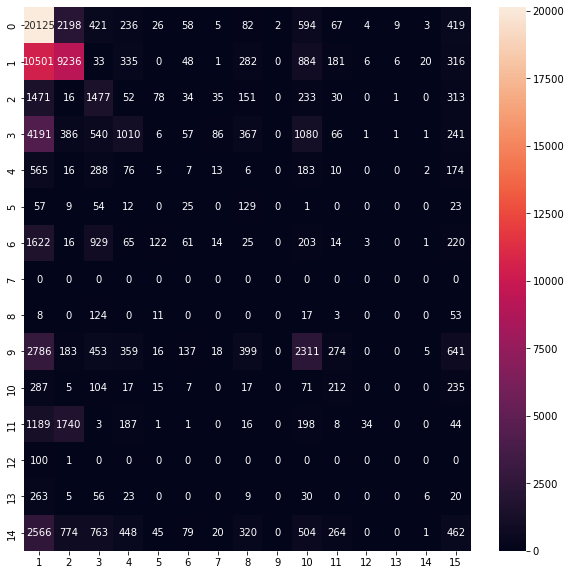

In [14]:
# Task 2a: Plot the confusion matrix of the given method

def confusion_matrix(y_pred_prob, y_test):
    cm = sklearn.metrics.confusion_matrix(
        y_true=y_test, 
        y_pred=rf_pred)
    return cm

cm = confusion_matrix(rf_pred, y_test)

import pandas as pd

df = pd.DataFrame(cm, columns = ['1','2','3', '4','5','6','7','8','9','10','11','12','13','14','15'])

plt.figure(figsize=(10,10))
sns.heatmap(df, annot=True, fmt='g')
cm

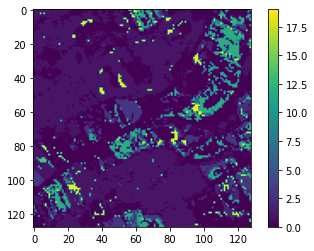

In [15]:
# TODO: Display the results in an image for one of the images in the test set

tpb = rf_pred.copy().reshape(-1, 128, 128)
plt.imshow(tpb[4])
plt.colorbar()
plt.show()

# Fluctuations of validation error 

In this task we explore fluctuations of validation error as a function of the size of validation set and the dependence of the validation error on the size of the training set. 
In order to explore fluctuations of the validation error as a function of the size of the validation set we use the following construction:

• Use the range(1, 1001, 200) K samples for training/fitting 5 methods using the given  method/notebook. 

• Consider five validation sets of sizes range(1, 101, 20).  

• Calculate the validation error for each of the sets as a function of K, for K ∈ {1, . . . , 801}. Plot the 
validation error for each of the five validation sets as a function of K in a figure (you will get five lines in the figure).

• Create one more figure, where for each training set with K samples you plot the variance of the validation error over the five validation sets, as a function of K. You will get five scattered points in this graph.

• Comment on your observations.


In [15]:
#Define a function to determine accuracy


def validation_error(X_train, y_train, X_test, y_test, sample_size_train, sample_size_test):
    
    #select random number of rowns from training data
    random_rows = np.random.choice(X_train.shape[0], size=sample_size_train, replace=False)
    
    #pull said rows from training data
    X_train_random = X_train[random_rows, :]
    y_train_random = y_train[random_rows]
    
    #train random forest classifier and make prediction
    rf_classifier = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0, n_jobs=-1).fit(X_train_random, y_train_random)
    prediction = rf_classifier.predict(X_test)
    
    #select random number of rowns from validation data
    random_rows_test = np.random.choice(y_test.shape[0], size=sample_size_test, replace=False)
    
    #pull said rows from validation data
    y_test_random = y_test[random_rows_test]
    
    #compute accruacy
    accuracy = sklearn.metrics.accuracy_score(y_true=y_test, y_pred=prediction)
    return accuracy

In [16]:
#create pandas dataframe
error_df = pd.DataFrame(columns=['samples_train', 'samples_test', 'accuracy'])


#write loop to iterate over both validation and training subsamples
for i in range(1, 1001, 200):
    for j in range(1, 101, 20):
        
        #initilise funktion error function
        output = validation_error(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, sample_size_train=i, sample_size_test=j)
        
        #add each result to the dataframe
        new_row = pd.DataFrame({'samples_train': [i], 'samples_test': [j], 'accuracy':[output]})
        error_df = pd.concat([error_df, new_row], ignore_index=True)

    
error_df= error_df.reset_index(drop=True)

#realise that error was asked, but being to lazy to fix it just do 1-acc
error_df['error'] = 1- error_df['accuracy']

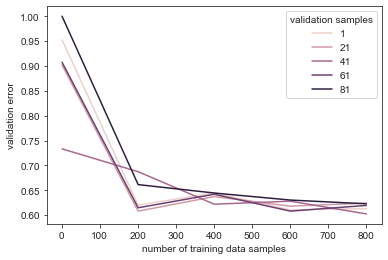

In [17]:
#plotting error as a funtion of training samples, grouped by validation samples
import seaborn as sns
sns.set_style("ticks")

p = sns.lineplot(data=error_df, x = 'samples_train', y='error', hue='samples_test')
p.set(xlabel='number of training data samples', ylabel='validation error')
plt.legend(title='validation samples')

plt.savefig(r'C:\Users\birgi\Desktop\Geoinformatics M.Sc\Big DAta\error.jpg', dpi=300)

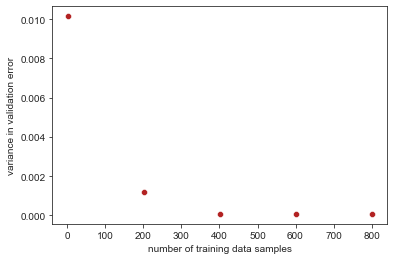

In [18]:
#plotting error varaince  as a funtion of training samples

#calculate variance
variance = error_df.groupby(['samples_train']).var()

#add new coloumn with number of training samples
variance['samples']=[1, 201, 401, 601, 801]

sns.set_style("ticks")

p = sns.scatterplot(data=variance, x = 'samples_train', y='error', color = 'firebrick')
p.set(xlabel='number of training data samples', ylabel='variance in validation error')


plt.savefig(r'C:\Users\birgi\Desktop\Geoinformatics M.Sc\Big DAta\variance.jpg', dpi=300)